In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
import re
import spacy
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Embedding,SpatialDropout1D,Bidirectional,Dropout
import demoji
from textblob import TextBlob
from wordcloud import WordCloud
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer

nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('omw-1.4')
warnings.filterwarnings("ignore")


df = pd.read_csv("C:/nlp/Fed_Scrape-2015-2023.csv",delimiter=',',nrows=20000)


df.drop('Unnamed: 0',inplace=True,axis=1)
df.head(10)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Date,Type,Text
0,20230412,0,The Federal Reserve on Wednesday released the ...
1,20230412,0,The minutes for each regularly scheduled meeti...
2,20230412,0,The minutes can be viewed on the Board's website.
3,20230412,0,"For media inquiries, e-mail [email protected] ..."
4,20230412,0,Minutes of the Federal Open Market Committee\r...
5,20230322,1,"March 21–22, 2023"
6,20230322,1,A joint meeting of the Federal Open Market Com...
7,20230322,1,"Attendance \r\nJerome H. Powell, Chair\r\nJohn..."
8,20230322,1,"Thomas I. Barkin, Raphael W. Bostic, Mary C. D..."
9,20230322,1,"James Bullard and Susan M. Collins, Presidents..."


In [2]:

print(df.isnull().sum())
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)



Date    0
Type    0
Text    0
dtype: int64
20


In [3]:

def clean_text(text):

    text = str(text).lower()
    text = re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9_]+)', '',text)

    text = re.sub(r'http\S+', '', text)

    text = re.sub(r'#(\w+)','',text)

    text = demoji.replace(text,'')

    text = re.sub(r'\s+',' ',text)
    text = re.sub(r'[^\w\s]', '',text)

    text = re.sub(r'\@w+|\#','',text)

    text = re.sub(r'ï½','',text)




    return text





def remove_stopwords(text):
    sw = set(stopwords.words("english"))
    tokens = word_tokenize(text)
    cleaned_tokens = [word for word in tokens if word.lower() not in sw]
    return " ".join(cleaned_tokens)




def lemmatizer(text):
    lemma = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemma_tokens = [lemma.lemmatize(token) for token in tokens]
    return " ".join(lemma_tokens)




df['Text'] = df['Text'].apply(lambda x: clean_text(x))
df['Text'] = df['Text'].apply(lambda x: remove_stopwords(x))
df['Text'] = df['Text'].apply(lambda x: lemmatizer(x))
df['Text'].head(10)







0    federal reserve wednesday released minute fede...
1    minute regularly scheduled meeting committee o...
2                          minute viewed board website
3    medium inquiry email email protected call 2024...
4    minute federal open market committee march 212...
5                                      march 2122 2023
6    joint meeting federal open market committee bo...
7    attendance jerome h powell chair john c willia...
8    thomas barkin raphael w bostic mary c daly lor...
9    james bullard susan collins president federal ...
Name: Text, dtype: object

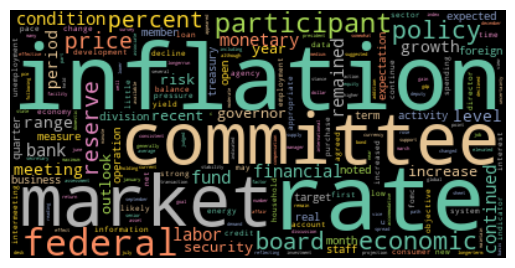

In [4]:
sample_txt = " ".join(i for i in df['Text'])

wc = WordCloud(colormap="Set2",collocations=False).generate(sample_txt)
plt.axis("off")
plt.imshow(wc,interpolation='bilinear')
plt.show()



In [5]:
blob = TextBlob(sample_txt)
most_common_words = FreqDist(blob.words).most_common(50)
print(f'top 50 most common words: {most_common_words}')


top 50 most common words: [('inflation', 5758), ('rate', 5558), ('committee', 5446), ('market', 5445), ('federal', 4827), ('participant', 4511), ('economic', 3732), ('policy', 3604), ('board', 3121), ('reserve', 2945), ('price', 2833), ('percent', 2769), ('would', 2664), ('condition', 2475), ('bank', 2402), ('monetary', 2315), ('financial', 2299), ('labor', 2140), ('fund', 2070), ('continued', 1972), ('remained', 1968), ('2', 1818), ('meeting', 1787), ('range', 1750), ('growth', 1732), ('period', 1713), ('level', 1650), ('security', 1636), ('governor', 1622), ('recent', 1620), ('risk', 1596), ('year', 1546), ('outlook', 1538), ('increase', 1537), ('expected', 1477), ('division', 1452), ('term', 1430), ('business', 1419), ('activity', 1414), ('measure', 1387), ('operation', 1381), ('quarter', 1363), ('noted', 1352), ('also', 1332), ('open', 1311), ('month', 1296), ('foreign', 1282), ('target', 1277), ('member', 1248), ('expectation', 1239)]


In [6]:


nlp = spacy.load("en_core_web_sm")


doc = nlp(sample_txt[:2000])


for ent in doc.ents:
    print(ent.text, "|",spacy.explain(ent.label_))


federal reserve | Companies, agencies, institutions, etc.
wednesday | Absolute or relative dates or periods
march 2122 2023 minute | Absolute or relative dates or periods
three week day | Absolute or relative dates or periods
2024522955 minute | Times smaller than a day
march 2122 2023 | Absolute or relative dates or periods
march 2122 2023 | Absolute or relative dates or periods
tuesday march 21 2023 1000 | Absolute or relative dates or periods
wednesday march | Absolute or relative dates or periods
2023 | Absolute or relative dates or periods
attendance jerome h | People, including fictional
john c williams | People, including fictional
michael barr michelle w bowman | People, including fictional
lisa cook | People, including fictional
goolsbee patrick harker philip n jefferson | People, including fictional
kashkari lorie k logan | People, including fictional
thomas barkin raphael w bostic | People, including fictional
daly loretta j mester sushmita | People, including fictional
jame

In [7]:
cv = CountVectorizer()


X = df['Text']
X = cv.fit_transform(X).toarray()
y = df['Type']





X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)




pa = PassiveAggressiveClassifier()
gnb = GaussianNB()
lr = LogisticRegression()
GBC= GradientBoostingClassifier()

def evaluate_sklearn_models(X_train,X_test,y_train,y_test,model):
    model = model.fit(X_train,y_train)
    pred = model.predict(X_test)
    clf_rpt = classification_report(y_test,pred)
    acc = accuracy_score(y_test, pred)
    print(f'{model.__class__.__name__}, --Classification Report-- {clf_rpt}; --Accuracy-- {acc*100:.2f}')
    return pred


gnb_pred = evaluate_sklearn_models(X_train, X_test, y_train, y_test, gnb)
lr_pred = evaluate_sklearn_models(X_train, X_test, y_train, y_test, lr)
pa_pred = evaluate_sklearn_models(X_train, X_test, y_train, y_test, pa)
GBC_pred = evaluate_sklearn_models(X_train,X_test,y_train,y_test,GBC)

GaussianNB, --Classification Report--               precision    recall  f1-score   support

           0       0.61      0.90      0.73       349
           1       0.98      0.88      0.93      1642

    accuracy                           0.88      1991
   macro avg       0.79      0.89      0.83      1991
weighted avg       0.91      0.88      0.89      1991
; --Accuracy-- 88.25
LogisticRegression, --Classification Report--               precision    recall  f1-score   support

           0       0.85      0.81      0.83       349
           1       0.96      0.97      0.97      1642

    accuracy                           0.94      1991
   macro avg       0.91      0.89      0.90      1991
weighted avg       0.94      0.94      0.94      1991
; --Accuracy-- 94.22
PassiveAggressiveClassifier, --Classification Report--               precision    recall  f1-score   support

           0       0.84      0.88      0.86       349
           1       0.97      0.96      0.97      1642

   

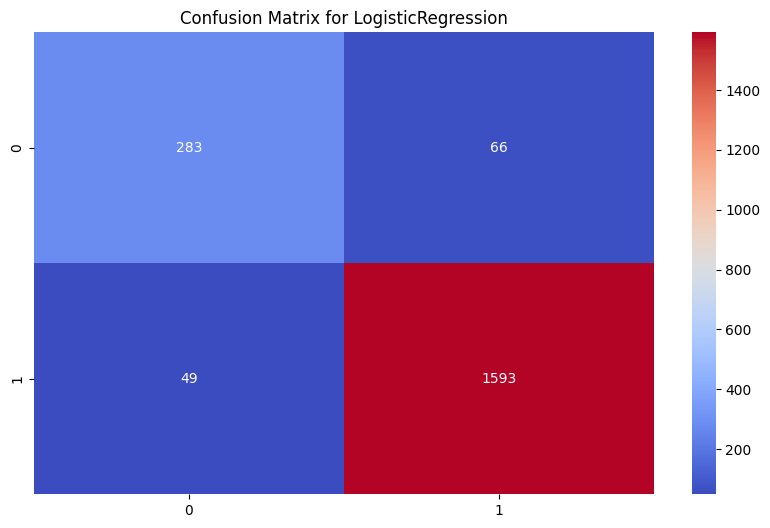

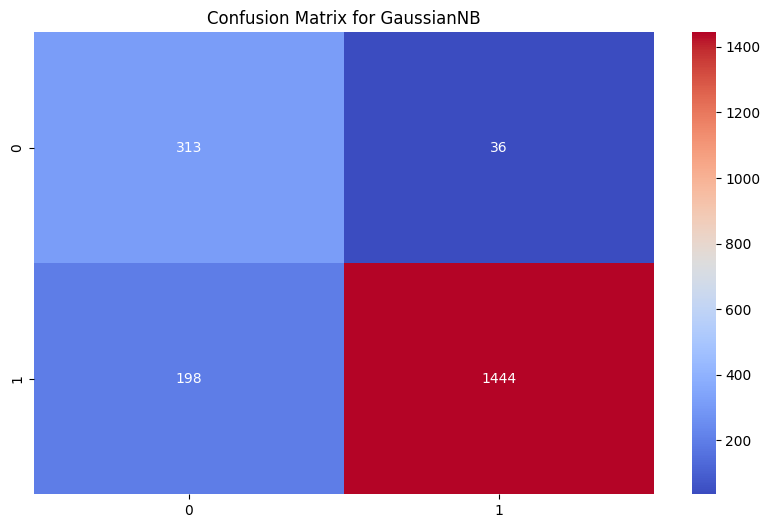

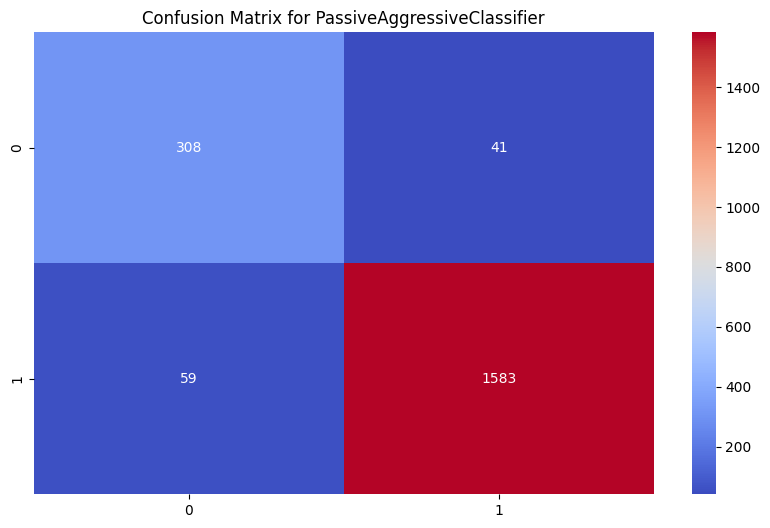

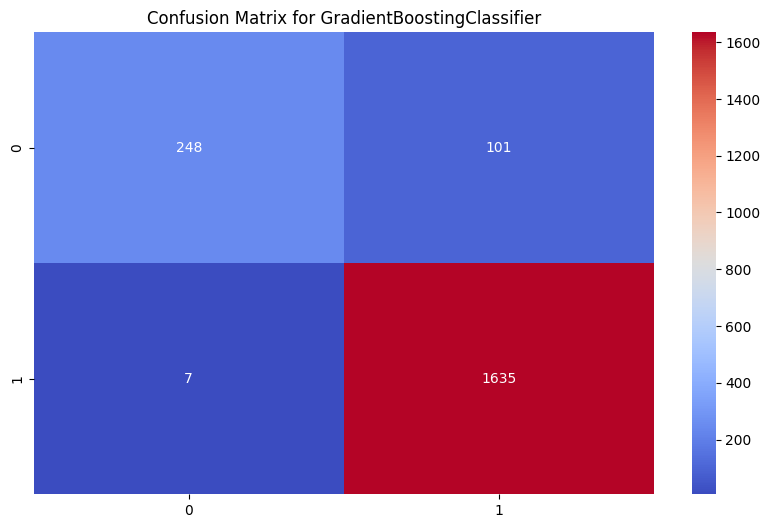

In [8]:
def plot_confusion_matrix(y_true,y_pred,model):
    confmat = confusion_matrix(y_test, y_pred)
    sns.heatmap(confmat,fmt='d',annot=True,cmap='coolwarm')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

plt.figure(figsize=(10,6))
plot_confusion_matrix(y_test, lr_pred, lr)


plt.figure(figsize=(10,6))
plot_confusion_matrix(y_test, gnb_pred, gnb)


plt.figure(figsize=(10,6))
plot_confusion_matrix(y_test, pa_pred, pa)


plt.figure(figsize=(10,6))
plot_confusion_matrix(y_test,GBC_pred,GBC)

In [9]:


X = df['Text']
y = df['Type']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
print(f'length of word index: {len(word_index)}')


X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


max_length = 0
for sequence in X_train:
    sequence_length = len(sequence)
    if sequence_length > max_length:
        max_length = sequence_length

print("Max Length of Sequences: ",max_length)

length of word index: 7240
Max Length of Sequences:  291


In [10]:


X_train = pad_sequences(X_train,padding="post")
X_test = pad_sequences(X_test,padding="post")


RNN = Sequential()
RNN.add(Embedding(len(word_index)+1,output_dim=300,input_length=max_length))
RNN.add(SpatialDropout1D(0.3))
RNN.add(Bidirectional(LSTM(250,dropout=0.1,recurrent_dropout=0.1)))
RNN.add(Dropout(0.2))
RNN.add(Dense(250,activation='relu'))
RNN.add(Dropout(0.1))
RNN.add(Dense(1,activation='sigmoid'))
RNN.summary()



RNN.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history = RNN.fit(X_train,y_train,epochs=5,batch_size=32,validation_split=0.1)
loss,acc = RNN.evaluate(X_test,y_test)
pred = RNN.predict(X_test)

print(f"Testing Loss: {loss:.2f}")
print(f"Testing Accuracy: {acc*100:.2f}")



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.8882 - loss: 0.2735 - val_accuracy: 0.9611 - val_loss: 0.0775
Epoch 2/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.9577 - loss: 0.0949 - val_accuracy: 0.9624 - val_loss: 0.0695
Epoch 3/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.9677 - loss: 0.0549 - val_accuracy: 0.9611 - val_loss: 0.0623
Epoch 4/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.9642 - loss: 0.0557 - val_accuracy: 0.9711 - val_loss: 0.0524
Epoch 5/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.9685 - loss: 0.0488 - val_accuracy: 0.9611 - val_loss: 0.0545
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.9589 - loss: 0.0776
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step
Testing Loss: 0.09
Testing Accuracy: 95.83
